# Semi-Supervised Learning на датасете Adult

В этом ноутбуке исследуются методы semi-supervised learning для работы с ограниченной разметкой. Сравниваются supervised baseline, self-training, Π-model и FixMatch-lite на задаче бинарной классификации с метриками Accuracy и F1.


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)


## 1. Подготовка данных

Загружаем датасет Adult и создаем разделение:
- **L (labeled)**: 5-10% размеченных примеров
- **U (unlabeled)**: оставшиеся примеры без меток
- **val, test**: валидация и тестирование

StandardScaler обучается только на L для избежания утечки информации.


In [2]:
adult = fetch_openml('adult', version=2, as_frame=True, parser='pandas')
X = adult.data
y = adult.target

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_numeric = X.select_dtypes(include=[np.number])
X_categorical = X.select_dtypes(exclude=[np.number])

for col in X_categorical.columns:
    X_categorical[col] = LabelEncoder().fit_transform(X_categorical[col].astype(str))

X_processed = pd.concat([X_numeric, X_categorical], axis=1)
X_processed = X_processed.values

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_processed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

X_train_full, X_val, y_train_full, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.15, random_state=42, stratify=y_train_full
)

print(f"Train full: {X_train_full.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Train full: (33212, 14), Val: (5861, 14), Test: (9769, 14)


In [3]:
labeled_ratio = 0.1

indices = np.arange(len(X_train_full))
labeled_indices, unlabeled_indices = train_test_split(
    indices, train_size=labeled_ratio, random_state=42, stratify=y_train_full
)

X_labeled = X_train_full[labeled_indices]
y_labeled = y_train_full[labeled_indices]

X_unlabeled = X_train_full[unlabeled_indices]
y_unlabeled = y_train_full[unlabeled_indices]

print(f"Labeled: {X_labeled.shape}, Unlabeled: {X_unlabeled.shape}")
print(f"Labeled class distribution: {np.bincount(y_labeled)}")
print(f"Unlabeled class distribution (ground truth): {np.bincount(y_unlabeled)}")


Labeled: (3321, 14), Unlabeled: (29891, 14)
Labeled class distribution: [2526  795]
Unlabeled class distribution (ground truth): [22739  7152]


In [4]:
scaler = StandardScaler()
X_labeled_scaled = scaler.fit_transform(X_labeled)
X_unlabeled_scaled = scaler.transform(X_unlabeled)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

input_dim = X_labeled_scaled.shape[1]
n_classes = len(np.unique(y_labeled))

print(f"Input dimension: {input_dim}, Number of classes: {n_classes}")


Input dimension: 14, Number of classes: 2


## 2. Аугментации для табличных данных

Определяем слабые и сильные аугментации:
- **weak**: малый Gaussian noise ($\sigma \approx 0.05$), малый feature dropout ($p \approx 0.05$)
- **strong**: больший noise ($\sigma \approx 0.15$), feature dropout ($p \approx 0.2$), feature scaling


In [20]:
class WeakAugmentation:
    def __init__(self, noise_std=0.05, dropout_prob=0.05):
        self.noise_std = noise_std
        self.dropout_prob = dropout_prob
    
    def __call__(self, x):
        noise = torch.randn_like(x) * self.noise_std
        x_aug = x + noise
        
        mask = torch.rand_like(x) > self.dropout_prob
        x_aug = x_aug * mask
        
        return x_aug

class StrongAugmentation:
    def __init__(self, noise_std=0.1, dropout_prob=0.1, scale_range=0.07):
        self.noise_std = noise_std
        self.dropout_prob = dropout_prob
        self.scale_range = scale_range
    
    def __call__(self, x):
        noise = torch.randn_like(x) * self.noise_std
        x_aug = x + noise
        
        mask = torch.rand_like(x) > self.dropout_prob
        x_aug = x_aug * mask
        
        scale = 1 + (torch.rand_like(x) * 2 - 1) * self.scale_range
        x_aug = x_aug * scale
        
        return x_aug

weak_aug = WeakAugmentation()
strong_aug = StrongAugmentation()


## 3. Базовая модель MLP

Простой MLP-классификатор для бинарной классификации:


In [6]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, n_classes=2):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, n_classes)
        )
    
    def forward(self, x):
        return self.network(x)

def evaluate_model(model, X, y, device='cpu'):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X).to(device)
        logits = model(X_tensor)
        probs = F.softmax(logits, dim=-1)
        preds = torch.argmax(probs, dim=-1).cpu().numpy()
    
    acc = accuracy_score(y, preds)
    f1 = f1_score(y, preds, average='binary')
    
    return acc, f1, preds


## 4. Supervised Baseline

Обучаем модель только на размеченных данных L для получения baseline.


In [7]:
def train_supervised(model, X_train, y_train, X_val, y_val, epochs=50, lr=1e-3, device='cpu'):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    
    best_val_acc = 0
    history = {'train_loss': [], 'val_acc': [], 'val_f1': []}
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            logits = model(x_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_acc, val_f1, _ = evaluate_model(model, X_val, y_val, device)
        
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")
    
    model.load_state_dict(best_model_state)
    return model, history


In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

print("\n" + "="*60)
print("Training Supervised Baseline")
print("="*60)

model_baseline = MLPClassifier(input_dim, hidden_dim=256, n_classes=n_classes)
model_baseline, history_baseline = train_supervised(
    model_baseline, X_labeled_scaled, y_labeled, X_val_scaled, y_val, 
    epochs=100, device=device
)

test_acc, test_f1, _ = evaluate_model(model_baseline, X_test_scaled, y_test, device)
print(f"\nBaseline Test Accuracy: {test_acc:.4f}, Test F1: {test_f1:.4f}")


Using device: cuda

Training Supervised Baseline
Epoch 10/100, Loss: 0.3097, Val Acc: 0.8447, Val F1: 0.6535
Epoch 20/100, Loss: 0.2813, Val Acc: 0.8420, Val F1: 0.6334
Epoch 30/100, Loss: 0.2615, Val Acc: 0.8418, Val F1: 0.6375
Epoch 40/100, Loss: 0.2478, Val Acc: 0.8376, Val F1: 0.6405
Epoch 50/100, Loss: 0.2323, Val Acc: 0.8360, Val F1: 0.6424
Epoch 60/100, Loss: 0.2163, Val Acc: 0.8336, Val F1: 0.6492
Epoch 70/100, Loss: 0.2051, Val Acc: 0.8301, Val F1: 0.6222
Epoch 80/100, Loss: 0.1910, Val Acc: 0.8313, Val F1: 0.6269
Epoch 90/100, Loss: 0.1910, Val Acc: 0.8325, Val F1: 0.6255
Epoch 100/100, Loss: 0.1706, Val Acc: 0.8251, Val F1: 0.6364

Baseline Test Accuracy: 0.8300, Test F1: 0.6461


## 5. Self-Training (Псевдоразметка)

Self-training использует уверенные предсказания модели на unlabeled данных как псевдометки:

1. Обучить модель на L
2. Получить предсказания на U, отобрать уверенные ($\max p \geq \tau$)
3. Объединить L с отобранными $\hat{U}$ → L'
4. Дообучить модель на L'


In [9]:
def get_pseudo_labels(model, X_unlabeled, threshold=0.9, device='cpu'):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X_unlabeled).to(device)
        logits = model(X_tensor)
        probs = F.softmax(logits, dim=-1)
        max_probs, pseudo_labels = torch.max(probs, dim=-1)
        
        confident_mask = max_probs >= threshold
        confident_indices = confident_mask.cpu().numpy()
        pseudo_labels = pseudo_labels.cpu().numpy()
    
    return confident_indices, pseudo_labels

def self_training(X_labeled, y_labeled, X_unlabeled, X_val, y_val, 
                  input_dim, n_classes, threshold=0.9, device='cpu'):
    print(f"\nSelf-training with threshold={threshold}")
    
    model = MLPClassifier(input_dim, hidden_dim=256, n_classes=n_classes)
    model, _ = train_supervised(model, X_labeled, y_labeled, X_val, y_val, epochs=50, device=device)
    
    confident_indices, pseudo_labels = get_pseudo_labels(model, X_unlabeled, threshold, device)
    
    print(f"Selected {confident_indices.sum()} confident samples out of {len(X_unlabeled)}")
    
    if confident_indices.sum() > 0:
        X_pseudo = X_unlabeled[confident_indices]
        y_pseudo = pseudo_labels[confident_indices]
        
        X_combined = np.vstack([X_labeled, X_pseudo])
        y_combined = np.concatenate([y_labeled, y_pseudo])
        
        print(f"Combined dataset size: {len(X_combined)}")
        
        model_refined = MLPClassifier(input_dim, hidden_dim=256, n_classes=n_classes)
        model_refined, _ = train_supervised(model_refined, X_combined, y_combined, X_val, y_val, 
                                           epochs=30, device=device)
        
        return model_refined
    else:
        print("No confident samples selected, returning initial model")
        return model


In [18]:
print("\n" + "="*60)
print("Self-Training")
print("="*60)

model_selftraining = self_training(
    X_labeled_scaled, y_labeled, X_unlabeled_scaled, X_val_scaled, y_val,
    input_dim, n_classes, threshold=0.99, device=device
)

test_acc, test_f1, _ = evaluate_model(model_selftraining, X_test_scaled, y_test, device)
print(f"\nSelf-Training Test Accuracy: {test_acc:.4f}, Test F1: {test_f1:.4f}")



Self-Training

Self-training with threshold=0.99
Epoch 10/50, Loss: 0.3060, Val Acc: 0.8434, Val F1: 0.6016
Epoch 20/50, Loss: 0.2795, Val Acc: 0.8415, Val F1: 0.6085
Epoch 30/50, Loss: 0.2692, Val Acc: 0.8391, Val F1: 0.6256
Epoch 40/50, Loss: 0.2413, Val Acc: 0.8406, Val F1: 0.6465
Epoch 50/50, Loss: 0.2335, Val Acc: 0.8381, Val F1: 0.6306
Selected 13323 confident samples out of 29891
Combined dataset size: 16644
Epoch 10/30, Loss: 0.0636, Val Acc: 0.8449, Val F1: 0.6368
Epoch 20/30, Loss: 0.0554, Val Acc: 0.8437, Val F1: 0.6425
Epoch 30/30, Loss: 0.0504, Val Acc: 0.8406, Val F1: 0.6528

Self-Training Test Accuracy: 0.8451, Test F1: 0.6619


## 6. Π-Model (Consistency Regularization)

Π-model минимизирует расстояние между предсказаниями модели на разных аугментациях:

$$\mathcal{L} = \mathcal{L}_{\text{sup}}(x_L, y_L) + \lambda_u \mathbb{E}_{x \in U} [D(p_{\text{weak}}, p_{\text{strong}})]$$

где $D$ — MSE или KL-дивергенция между предсказаниями.


In [21]:
def train_pi_model(model, X_labeled, y_labeled, X_unlabeled, X_val, y_val, 
                   epochs=50, lr=1e-3, lambda_u=1.0, rampup_epochs=20, device='cpu'):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion_sup = nn.CrossEntropyLoss()
    
    labeled_dataset = TensorDataset(torch.FloatTensor(X_labeled), torch.LongTensor(y_labeled))
    unlabeled_dataset = TensorDataset(torch.FloatTensor(X_unlabeled))
    
    labeled_loader = DataLoader(labeled_dataset, batch_size=32, shuffle=True)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=128, shuffle=True)
    
    best_val_acc = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss_sup = 0
        train_loss_unsup = 0
        
        current_lambda = lambda_u * min(1.0, epoch / rampup_epochs)
        
        unlabeled_iter = iter(unlabeled_loader)
        
        for x_labeled, y_labeled_batch in labeled_loader:
            x_labeled = x_labeled.to(device)
            y_labeled_batch = y_labeled_batch.to(device)
            
            logits_labeled = model(x_labeled)
            loss_sup = criterion_sup(logits_labeled, y_labeled_batch)
            
            try:
                x_unlabeled_batch = next(unlabeled_iter)[0].to(device)
            except StopIteration:
                unlabeled_iter = iter(unlabeled_loader)
                x_unlabeled_batch = next(unlabeled_iter)[0].to(device)
            
            x_weak = weak_aug(x_unlabeled_batch)
            x_strong = strong_aug(x_unlabeled_batch)
            
            logits_weak = model(x_weak)
            logits_strong = model(x_strong)
            
            probs_weak = F.softmax(logits_weak, dim=-1)
            probs_strong = F.softmax(logits_strong, dim=-1)
            
            loss_unsup = F.mse_loss(probs_weak, probs_strong)
            
            loss = loss_sup + current_lambda * loss_unsup
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss_sup += loss_sup.item()
            train_loss_unsup += loss_unsup.item()
        
        train_loss_sup /= len(labeled_loader)
        train_loss_unsup /= len(labeled_loader)
        
        val_acc, val_f1, _ = evaluate_model(model, X_val, y_val, device)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Sup Loss: {train_loss_sup:.4f}, "
                  f"Unsup Loss: {train_loss_unsup:.4f}, λ_u: {current_lambda:.3f}, "
                  f"Val Acc: {val_acc:.4f}")
    
    model.load_state_dict(best_model_state)
    return model


In [22]:
print("\n" + "="*60)
print("Π-Model Training")
print("="*60)

model_pimodel = MLPClassifier(input_dim, hidden_dim=256, n_classes=n_classes)
model_pimodel = train_pi_model(
    model_pimodel, X_labeled_scaled, y_labeled, X_unlabeled_scaled, X_val_scaled, y_val,
    epochs=80, lambda_u=0.1, rampup_epochs=20, device=device
)

test_acc, test_f1, _ = evaluate_model(model_pimodel, X_test_scaled, y_test, device)
print(f"\nΠ-Model Test Accuracy: {test_acc:.4f}, Test F1: {test_f1:.4f}")



Π-Model Training
Epoch 10/80, Sup Loss: 0.3044, Unsup Loss: 0.0169, λ_u: 0.045, Val Acc: 0.8456
Epoch 20/80, Sup Loss: 0.2790, Unsup Loss: 0.0198, λ_u: 0.095, Val Acc: 0.8449
Epoch 30/80, Sup Loss: 0.2551, Unsup Loss: 0.0255, λ_u: 0.100, Val Acc: 0.8452
Epoch 40/80, Sup Loss: 0.2352, Unsup Loss: 0.0313, λ_u: 0.100, Val Acc: 0.8388
Epoch 50/80, Sup Loss: 0.2158, Unsup Loss: 0.0331, λ_u: 0.100, Val Acc: 0.8340
Epoch 60/80, Sup Loss: 0.2109, Unsup Loss: 0.0381, λ_u: 0.100, Val Acc: 0.8336
Epoch 70/80, Sup Loss: 0.1851, Unsup Loss: 0.0411, λ_u: 0.100, Val Acc: 0.8302
Epoch 80/80, Sup Loss: 0.1869, Unsup Loss: 0.0442, λ_u: 0.100, Val Acc: 0.8275

Π-Model Test Accuracy: 0.8314, Test F1: 0.6296


## 7. FixMatch-lite

FixMatch комбинирует псевдоразметку и consistency regularization:

$$\mathcal{L}_{\text{fix}} = \mathbb{E}_{x \in U} \mathbb{1}[\max p_{\text{weak}}(x) \geq \tau] \cdot \text{CE}(\arg\max p_{\text{weak}}(x), p_{\text{strong}}(x))$$

Используем уверенные предсказания на weak аугментации для обучения на strong аугментациях.


In [13]:
def train_fixmatch(model, X_labeled, y_labeled, X_unlabeled, X_val, y_val,
                   epochs=50, lr=1e-3, lambda_u=1.0, threshold=0.9, device='cpu'):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion_sup = nn.CrossEntropyLoss()
    criterion_unsup = nn.CrossEntropyLoss(reduction='none')
    
    labeled_dataset = TensorDataset(torch.FloatTensor(X_labeled), torch.LongTensor(y_labeled))
    unlabeled_dataset = TensorDataset(torch.FloatTensor(X_unlabeled))
    
    labeled_loader = DataLoader(labeled_dataset, batch_size=32, shuffle=True)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=128, shuffle=True)
    
    best_val_acc = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss_sup = 0
        train_loss_unsup = 0
        n_confident = 0
        
        unlabeled_iter = iter(unlabeled_loader)
        
        for x_labeled, y_labeled_batch in labeled_loader:
            x_labeled = x_labeled.to(device)
            y_labeled_batch = y_labeled_batch.to(device)
            
            logits_labeled = model(x_labeled)
            loss_sup = criterion_sup(logits_labeled, y_labeled_batch)
            
            try:
                x_unlabeled_batch = next(unlabeled_iter)[0].to(device)
            except StopIteration:
                unlabeled_iter = iter(unlabeled_loader)
                x_unlabeled_batch = next(unlabeled_iter)[0].to(device)
            
            with torch.no_grad():
                x_weak = weak_aug(x_unlabeled_batch)
                logits_weak = model(x_weak)
                probs_weak = F.softmax(logits_weak, dim=-1)
                max_probs, pseudo_labels = torch.max(probs_weak, dim=-1)
                confident_mask = max_probs >= threshold
            
            if confident_mask.sum() > 0:
                x_strong = strong_aug(x_unlabeled_batch)
                logits_strong = model(x_strong)
                
                loss_unsup_all = criterion_unsup(logits_strong, pseudo_labels)
                loss_unsup = (loss_unsup_all * confident_mask).mean()
                
                n_confident += confident_mask.sum().item()
            else:
                loss_unsup = torch.tensor(0.0, device=device)
            
            loss = loss_sup + lambda_u * loss_unsup
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss_sup += loss_sup.item()
            train_loss_unsup += loss_unsup.item()
        
        train_loss_sup /= len(labeled_loader)
        train_loss_unsup /= len(labeled_loader)
        
        val_acc, val_f1, _ = evaluate_model(model, X_val, y_val, device)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Sup Loss: {train_loss_sup:.4f}, "
                  f"Unsup Loss: {train_loss_unsup:.4f}, Confident: {n_confident}, "
                  f"Val Acc: {val_acc:.4f}")
    
    model.load_state_dict(best_model_state)
    return model


In [14]:
print("\n" + "="*60)
print("FixMatch-lite Training")
print("="*60)

model_fixmatch = MLPClassifier(input_dim, hidden_dim=256, n_classes=n_classes)
model_fixmatch = train_fixmatch(
    model_fixmatch, X_labeled_scaled, y_labeled, X_unlabeled_scaled, X_val_scaled, y_val,
    epochs=80, lambda_u=1.0, threshold=0.9, device=device
)

test_acc, test_f1, _ = evaluate_model(model_fixmatch, X_test_scaled, y_test, device)
print(f"\nFixMatch Test Accuracy: {test_acc:.4f}, Test F1: {test_f1:.4f}")



FixMatch-lite Training
Epoch 10/80, Sup Loss: 0.3074, Unsup Loss: 0.0401, Confident: 7888, Val Acc: 0.8427
Epoch 20/80, Sup Loss: 0.2883, Unsup Loss: 0.0428, Confident: 8250, Val Acc: 0.8442
Epoch 30/80, Sup Loss: 0.2642, Unsup Loss: 0.0489, Confident: 8496, Val Acc: 0.8463
Epoch 40/80, Sup Loss: 0.2451, Unsup Loss: 0.0595, Confident: 8729, Val Acc: 0.8441
Epoch 50/80, Sup Loss: 0.2270, Unsup Loss: 0.0583, Confident: 9044, Val Acc: 0.8388
Epoch 60/80, Sup Loss: 0.2192, Unsup Loss: 0.0714, Confident: 9055, Val Acc: 0.8422
Epoch 70/80, Sup Loss: 0.2010, Unsup Loss: 0.0732, Confident: 9306, Val Acc: 0.8415
Epoch 80/80, Sup Loss: 0.1981, Unsup Loss: 0.0775, Confident: 9222, Val Acc: 0.8357

FixMatch Test Accuracy: 0.8389, Test F1: 0.6442


## 8. Сравнение методов

Сводная таблица результатов всех методов на test множестве.


In [15]:
results = {}

models = {
    'Supervised Baseline': model_baseline,
    'Self-Training': model_selftraining,
    'Π-Model': model_pimodel,
    'FixMatch': model_fixmatch
}

for name, model in models.items():
    acc, f1, _ = evaluate_model(model, X_test_scaled, y_test, device)
    results[name] = {'Accuracy': acc, 'F1-Score': f1}

results_df = pd.DataFrame(results).T
print("\n" + "="*80)
print("COMPARISON OF ALL METHODS")
print("="*80)
print(results_df.to_string())

print(f"\nImprovement over baseline:")
baseline_acc = results['Supervised Baseline']['Accuracy']
for name in ['Self-Training', 'Π-Model', 'FixMatch']:
    improvement = (results[name]['Accuracy'] - baseline_acc) * 100
    print(f"{name}: +{improvement:.2f}% accuracy")



COMPARISON OF ALL METHODS
                     Accuracy  F1-Score
Supervised Baseline  0.829972  0.646069
Self-Training        0.846555  0.650990
Π-Model              0.839288  0.628490
FixMatch             0.838878  0.644213

Improvement over baseline:
Self-Training: +1.66% accuracy
Π-Model: +0.93% accuracy
FixMatch: +0.89% accuracy


## 9. Визуализация: Матрицы ошибок

Сравниваем confusion matrices для разных методов.


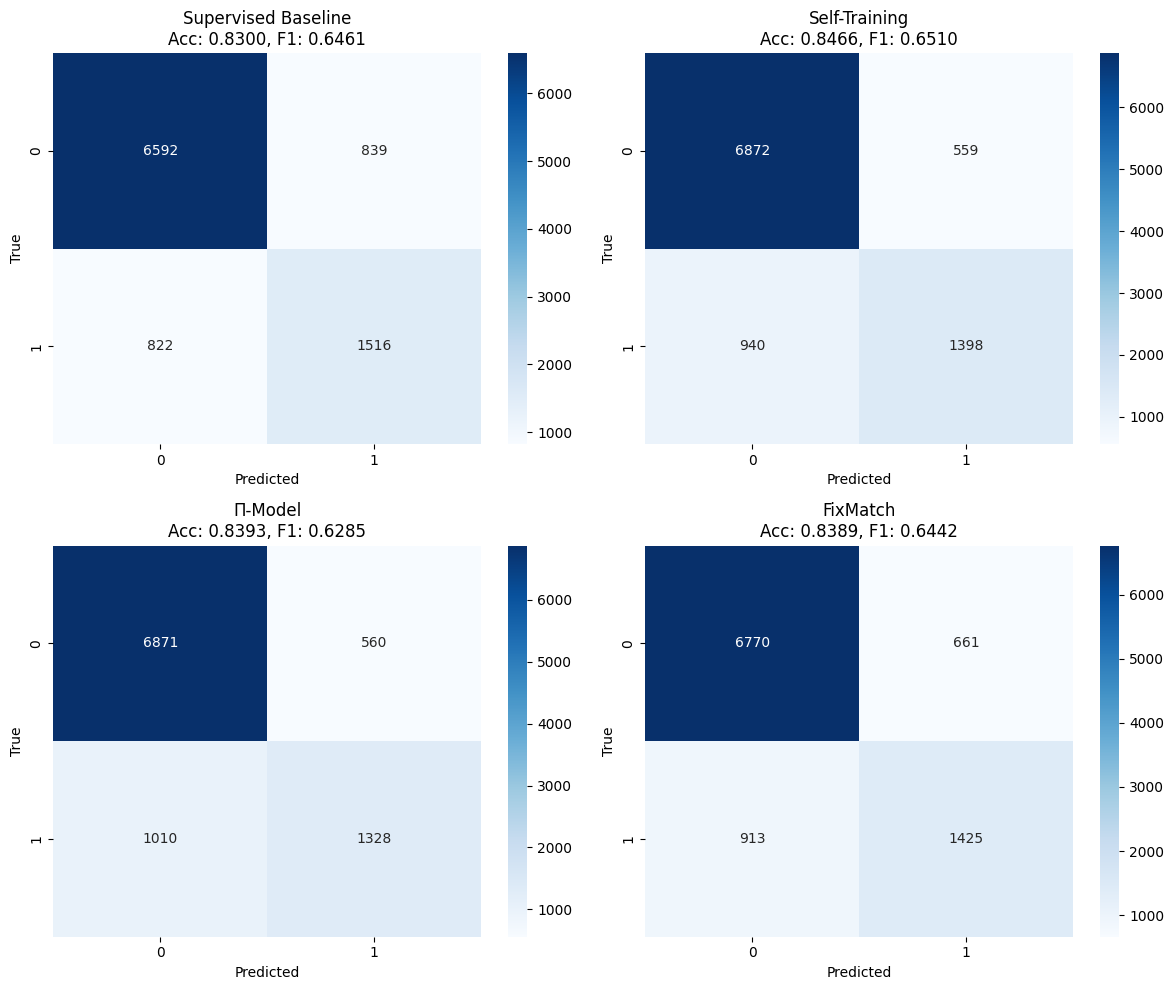

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, (name, model) in enumerate(models.items()):
    _, _, preds = evaluate_model(model, X_test_scaled, y_test, device)
    cm = confusion_matrix(y_test, preds)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'{name}\nAcc: {results[name]["Accuracy"]:.4f}, F1: {results[name]["F1-Score"]:.4f}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('True')

plt.tight_layout()
plt.show()
